# Lecture 18: Dimensionality reduction

![](https://www.tensorflow.org/images/colab_logo_32px.png)
[Run in colab](https://colab.research.google.com/drive/19J80Hg1ZLxLrpHWbgxFZoyPfql_AdeGN)

In [1]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2025-02-27 23:21:48


## Overview of dimensionality reduction

* Many problems have thousands or millions of features.
* Want to reduce the number of dimensions, i.e. features.
* Dimensionality reduction is (typically) lossy.

### Disadvantages

* It may (or may not) speed up training but (almost certainly) can degrade resulting performance.
* Also makes pipelines more complex.

$\Rightarrow$ Should always try using original data before considering dimensionality reduction.

### Advantages

* Can make problems possible, which otherwise would have been intractible.
* Very useful for visualization (2D, 3D representations are more intuitive).

### Curse of Dimensionality

Many things behave differently in high dimensional space.

Our intuition is built from our experience of the 3D world and often fails in higher dimensions.

For example:
- Pick a random point in a unit square (a 1 × 1 square), it will have only about a 0.4% chance of being located less than 0.001 from a border (in other words, it is very unlikely that a random point will be “extreme” along any dimension).
- But in a 10,000-dimensional unit hypercube (a 1 × 1 × ⋯ × 1 cube, with ten thousand 1s), this probability is greater than 99.999999%. Most points in a high-dimensional hypercube are very close to the border.

### Two main approaches for dimensionality reduction

1. Projection
2. Manifold learning

#### Projection 

- In most real-world problems, training instances are not spread out uniformly across all dimensions. 
- Many features are almost constant, while others are highly correlated. 
- As a result, all training instances actually lie within (or close to) a much lower-dimensional subspace

For example, consider the following 3D data-set lying close to a 2D subspace.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture18_Images/Projection.png" alt="data-layout" width="700" style="display:block; margin:auto"/>

[Source: Geron]

Data can be projected to a 2D plane without losing too much information.  

We've reduced the dimension of the data from 3 to 2.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture18_Images/projection_2d.png" alt="data-layout" width="700" style="display:block; margin:auto"/>

[Source: Geron]

#### Manifold learning

However, projection is not always the best approach for dimensionality reduction.  

Some data-sets may live of spaces (manifolds) that twist and turn.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture18_Images/swiss_roll.png" alt="data-layout" width="500" style="display:block; margin:auto"/>

##### Projection versus unrolling

Projecting would squash layers of the swiss roll (left plot), whereas better to "unroll" the swiss roll (right plot).

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture18_Images/swiss_roll_unrolled.png" alt="data-layout" width="800" style="display:block; margin:auto"/>


##### Manifold hypothesis

Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie; this is called *Manifold Learning*. 

It relies on the manifold hypothesis.

> Manifold hypothesis: most real-world high-dimensional data-sets lie close to a much lower dimensional manifold. This assumption is very often empirically observed.


## Principal component analysis (PCA) 

Most popular dimensionality reduction algorithm.

1. Find hyperplane that lies closest to the data.
2. Projects data onto it.


### Principal components

Choose directions in the data that preserve the maximum variability.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture18_Images/pca_variance.png" alt="data-layout" width="800" style="display:block; margin:auto"/>

[Source: Geron]

PCA finds the direction that accounts for the largest amount of *variance* in the data-set.

It then finds the next direction, orthogonal to the first, that accounts for largest amount of remaining variance.

Process repeats, up until the full dimension of the data.  But typically the majority of variance in the data is captured in many fewer dimensions than the maximum number.

Each axis vector is called a principal component.

Principal components found by Singular Value Decomposition (SVD), a matrix factorization technique, of the feature matrix $X$.

The principal components are the eigenvectors of the covariance matrix of the data $X^\text{T} X$

SVD of $X$ is given by:

$$X=U \Sigma V^T,$$
 
where the columns of $V$ give the principal components (which are normalised and orthogonal).

See the [tutorial here](https://arxiv.org/abs/1404.1100) for further details about PCA.

**Note: PCA assumes data is centered around origin. Scikit-Learn PCA will adjust data for you if needed.**

#### Example

Generate example data

In [2]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

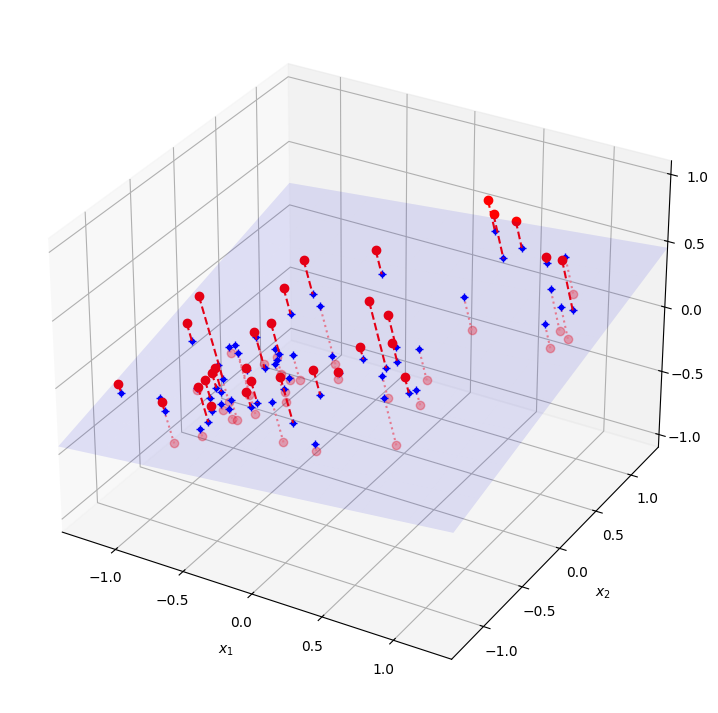

In [4]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1]);

Compute SVD

In [5]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
V = Vt.T
c1 = V[:,0]
c2 = V[:,1]

In [6]:
c1, c2

(array([0.67857588, 0.70073508, 0.22023881]),
 array([-0.72817329,  0.6811147 ,  0.07646185]))

Reconstruct $\Sigma$ from `s`:

In [7]:
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)

Check recover `X_centered`:

In [8]:
assert np.allclose(X_centered, U @ Σ @ Vt)

### Projecting down to d dimensions

Once principal components identified, can project data onto the hyperplane defined by first $d$ principal components.

Can be performed by the dot product between the data principal components.

1. Construct project matrix $P$ by taking first $d$ columns of $V$.
2. Multiple feature matrix by projection matrix to recover lower dimensional representation of the data: $X_d = X P$.


#### Check sizes

For $X$ of size $m \times n$, i.e. $n$ features and $m$ data instances, the matrices have the following sizes:

- $V$ is of size $n \times n$.
- $P$ (first $d$ columns of $V$) is of size $n \times d$.
- $X_d = X P$ is of size $m \times d$.

In [9]:
W2 = Vt[:2].T
X2D = X_centered @ W2

In [10]:
print(f"Original dimension is {X_centered.shape[-1]}")
print(f"Reduced dimension is {X2D.shape[-1]}")

Original dimension is 3
Reduced dimension is 2


### Scikit-Learn PCA

Scikit-Learn's PCA support also uses SVD but makes things even easier.

You can access each principal component using ```components_``` variable

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [12]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

### Explained variance ratio

*Explained variance ratio* is a very useful metric.

Gives the proportion of dataset variance along the axis of each principal component.

In [13]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

The first dimension explains about 76% of the variance, while the second explains about 15%.

By projecting down to 2D, we lost about 9% of the variance:

In [14]:
1 - pca.explained_variance_ratio_.sum()

np.float64(0.09028309326742034)

### Choosing the right number of dimensions

Compute the explained variance cumulatively to see how much captured by a given number of principal components.

In [15]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

np.int64(154)

So we capture $\geq95$% of the variance in $154$ dimensions.

Compared to original dimensionality of $28 \times 28 =784$), we compress to $\sim 20$% of the original size.

Scikit-Learn also has built in functionality to automatically select number of principal components that capture a given level of variance.

In [16]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [17]:
pca.n_components_

np.int64(154)

### PCA for compression

We can also reconstruct high dimensional representation from compressed representation.

Compression is lossy, so we won't recover the original high dimensional representation perfectly.

Example applying PCA to MNIST dataset with 95% preservation = results in ~150 features (original = 28x28 = 784)

Since principal components are orthogonal, we can estimate a recovered high dimensional representation by

$$X_\text{recovered} = X_{d} P^\text{T}.$$

In [18]:
X_recovered = pca.inverse_transform(X_reduced)

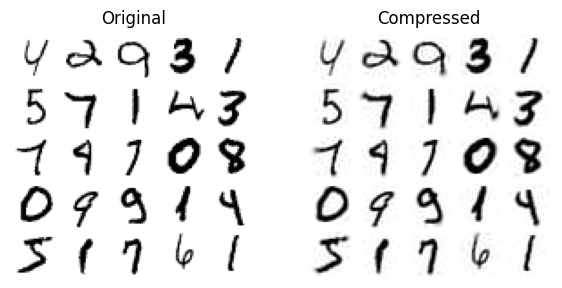

In [19]:
plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

### Randomized PCA 

*Randomized PCA* quickly find an approximation of the first first $d$ principal components.

It is much quicker than the full SVD approach.

Its computational complexity is ${\mathcal O}( m\times d^2) + {\mathcal O}( d^3)$, instead of ${\mathcal O}( m \times n^2) + {\mathcal O}( n^3)$, so it is dramatically faster than the previous algorithms when $d$ is much smaller than $n$.

In [20]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [21]:
rnd_pca.n_components_

154

### Incremental PCA 

One problem with PCA is that it requires the entire training set to be read into memory at once.  Thus, cannot apply to very large training data-sets. 

Instead *Incremental PCA (IPCA)* splits the data into batches, and allows for combination. 



In [22]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [23]:
inc_pca.n_components_

154

**Exercises:** *You can now complete Exercise 1 in the exercises associated with this lecture.*

## Random projections

Even with randomized or incremental PCA, PCA can be too computationally expensive for very large data-sets.

An alternative it to consider *random* projections to lower dimensional spaces through linear projections.

Random projections can actually preserve distances reasonably well.  Hence, two similar data instances remain similar after projection.  Similarly, two very different data instances remain very different after projection.

The more dimensions that are dropped, the more information is lost, and hence the more distances get distorted.

### Selecting the reduced dimension size

There is some deep mathematical theory that specifies how much dimensions can be compressed in order to ensure distances are distorted by less than some tolerance $\epsilon$.  

This is called the *Johnson-Lindenstrauss* minimum dimension:

$$d \geq \frac{4 \log(m)}{\epsilon^2/2 - \epsilon^3/3}.$$

(Doesn't depend on number of features $n$.)

### Example

For example:

In [24]:
m, ε = 1_000, 0.1

d = int(4 * np.log(m) / (ε ** 2 / 2 - ε ** 3 / 3))
d

5920

Or using Scikit-Learn:

In [25]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim


d = johnson_lindenstrauss_min_dim(m, eps=ε)
d

np.int64(5920)

Then can compute a random projection down to dimension $d$:

In [26]:
n = 8_000
np.random.seed(42)

# Radom projection matrix
P = np.random.randn(d, n) / np.sqrt(d)  # std dev = square root of variance

X = np.random.randn(m, n)  # generate a fake dataset
X_reduced = X @ P.T
X_reduced.shape

(1000, 5920)

Or use Scikit-Learn built in functionality:

In [27]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)  
X_reduced.shape

(1000, 5920)

## Locally linear embedding (LLE)

Locally linear embedding (LLE) is a powerful non-linear dimensionality reduction tool.

It is a form of *manifold learning* and doesn't rely on projections.

LLE measures how each instance relates to closest neighbors, then looks for low-D representation where local relations are best preserved.

### First Step: linearly modelling local relationships

- First, for each training instance $x^{(i)}$, the algorithm identifies its $k$ closest neighbours.
- Then tries to reconstruct $x^{(i)}$ as a linear weighted sum of these neighbors.

More specifically, it finds the weights $w_{ij}$ such that the squared distance between $x^{(i)}$ and $\sum_{j=1}^m w_{ij}x^{(j)}$ is as small as possible, assuming $w_{ij}=0$ if $x^{(j)}$ is not one of the $k$-nearest neighbours of $x^{(i)}$.

That is, solve the minimisation problem

$$
\text{argmin}_{W} \sum_{i=1}^m \left( x^{(i)} - \sum_{j=1}^m w_{ij}x^{(j)} \right)^2 ,
$$

where $W$ is the matrix of weights.  Note that weights are constrained to be normalised such that $\sum_j w_{ij}=1$.

### Second step: reducing dimensionality while preserving relationships

The second step is to map the training instances into a $d$-dimensional space (where $d < n$) while preserving these local relationships as much as possible.

If $z^{(i)}$ is the d-space equivalent of $x^{(i)}$ then we want the squared distance between $z^{(i)}$ and $\sum_{i=1}^m w_{ij}z^{(j)}$ to be as small as possible, given **the fixed set of weights** from step 1. 

That is, solve the minimisation problem

$$
\text{argmin}_{Z} \sum_{i=1}^m \left( z^{(i)} - \sum_{j=1}^m \hat{w}_{ij}z^{(j)} \right)^2 ,
$$

where $Z$ is the matrix of lower dimensional positions and $\hat{w}_{ij}$ are the weights determined in step 1.

Note that step 2 optimises positions of $z$ for fixed $w$, while step 1 optimises the $w$ for fixed positions $x$



### Example

#### Plot swiss roll

In [28]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

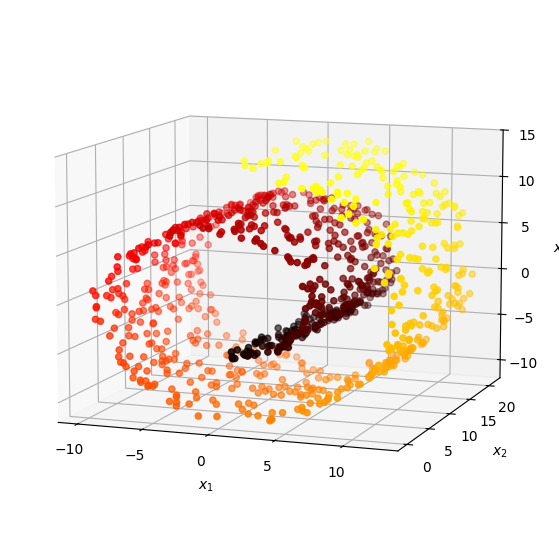

In [29]:
from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)

#### LLE

In [30]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

Text(0.5, 1.0, 'Unrolled swiss roll using LLE')

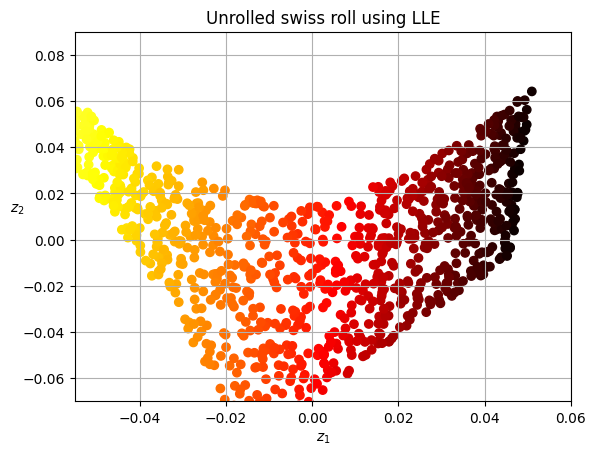

In [31]:
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)
plt.title("Unrolled swiss roll using LLE")

Swiss roll is unrolled and distances between instances are well preserved locally.

However, distances not preserved on a larger scale.